In [1]:
import os
import pickle
import sys
sys.path.append('..')
from mtDNAsim import *

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import re
import seaborn as sns

In [3]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [4]:
from tqdm.notebook import tqdm

In [748]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

In [105]:
rf_data = pd.DataFrame()
path = '/data3/wangkun/mtsim_res/20240903/'
for model in os.listdir(path):
    if model == 'test':
        continue
    for simid in os.listdir(f'{path}/{model}'):
        try:
            rft = pd.read_csv(f'{path}/{model}/{simid}/rf_dist.txt', sep='\t')
            rf_data = pd.concat((rf_data, rft),ignore_index=True)
        except:
            pass

In [106]:
rf_data['seq'][rf_data['seq']!='_seq'] = 'no'

/tmp/ipykernel_89187/157854779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_data['seq'][rf_data['seq']!='_seq'] = 'no'


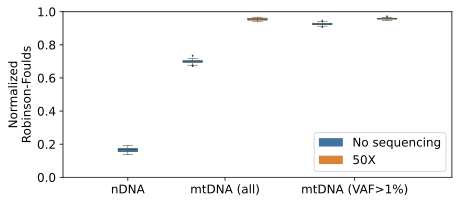

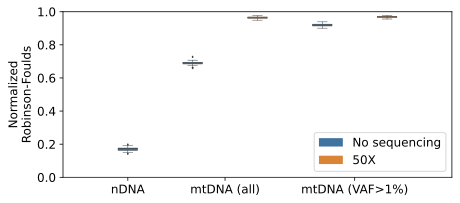

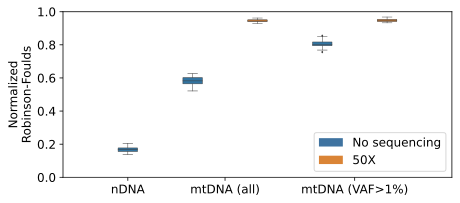

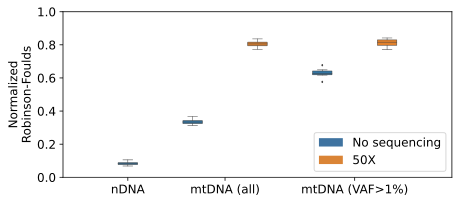

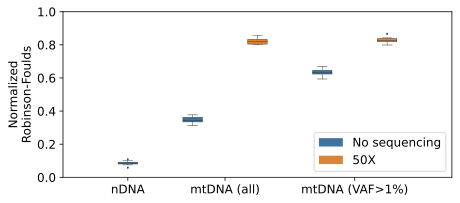

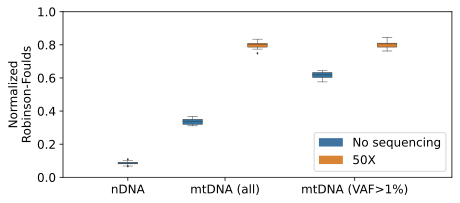

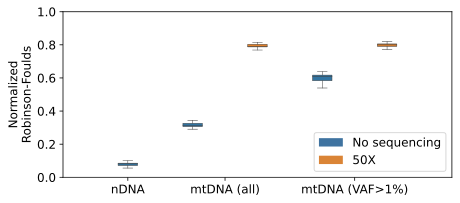

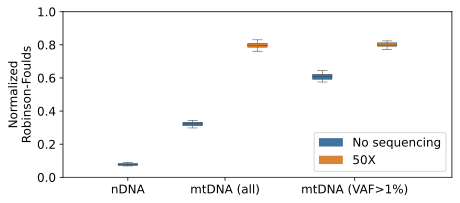

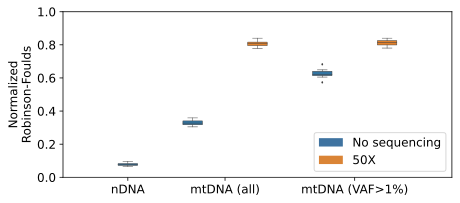

In [139]:
generation = 30
heterp = 10
for generation in [30, 130, 330]:
    for heterp in [0, 10, 100]:
        rf_tmp = rf_data[rf_data['model']==f'const_{heterp}']
        bp_dat = []

        rf_tmp_1 = rf_tmp[(rf_tmp['gen']==generation)&(rf_tmp['type']=='nDNA')]
        bp_dat.append(np.array(rf_tmp_1['rf']/rf_tmp_1['maxrf']).flatten())

        for cutoff in [0, 0.01]:
            for seq in ['no', '_seq']:
                rf_tmp_1 = rf_tmp[(rf_tmp['seq']==seq)&(rf_tmp['gen']==generation)&(rf_tmp['type']=='mtDNA')&(rf_tmp['cutoff']==cutoff)]
                bp_dat.append(np.array(rf_tmp_1['rf']/rf_tmp_1['maxrf']).flatten())


        colors=sns.color_palette(['tab:blue','tab:blue','tab:orange','tab:blue','tab:orange'])
        fig, ax = plt.subplots(figsize=(7,3))
        ax = sns.boxplot(bp_dat, ax=ax, width=0.3, palette=colors, linewidth=0.5, fliersize=1)
        ax.set_ylabel('Normalized\nRobinson-Foulds')

        ax.set_xlim((-1,5))

        legend_elements = []

        legend_elements.append(Patch(facecolor='#3f73a0',label='No sequencing'))
        legend_elements.append(Patch(facecolor='#da8436',label='50X'))
        ax.legend(handles=legend_elements, loc=4)
        ax.set_xticks([0, 1.5, 3.5], ['nDNA', 'mtDNA (all)', 'mtDNA (VAF>1%)'])
        # ax.set_title(f'Root cell heteroplasmy={heterp}')
        ax.set_ylim((0, 1))
        plt.savefig(f'../figs/rf_boxplot_{generation}_{heterp}.pdf')

  0%|          | 0/9326 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1141 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/1020 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/9023 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/919 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


  0%|          | 0/934 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  freq_samp = read_cnt/depth


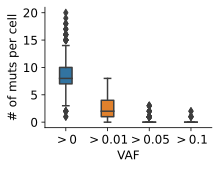

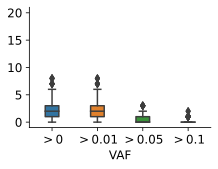

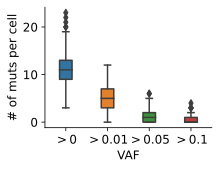

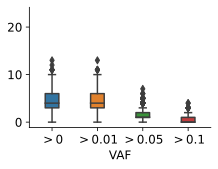

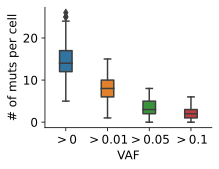

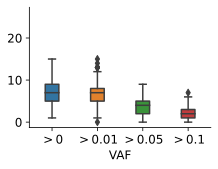

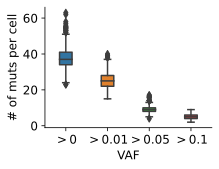

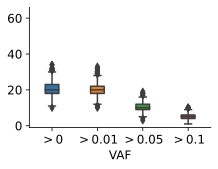

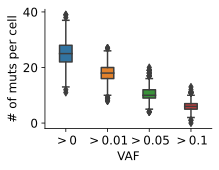

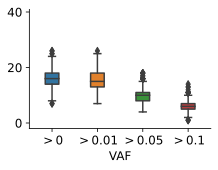

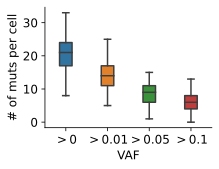

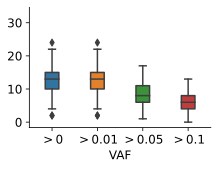

In [172]:
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/714932/',
             '/data3/wangkun/mtsim_res/20240903/const_100/11506/']:
    heterp = path.split('const_')[1].split('/')[0]
    for gen in [30, 130, 330]:
        mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
        mt_freq = sparse_freq(mts)
        if gen == 30:
            tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
            sel_cells = [i.name for i in tree.get_terminals()]
            mt_freq = mt_freq.loc[sel_cells]

        mt_freq_samp = sequence_sim(mt_freq, 50, n=2.5)

        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            num_vaf.append(np.sum(mt_freq>i, axis=1).to_numpy())
            
        fig, ax = plt.subplots(figsize=(3.2, 2.5))
        # fig, ax = plt.subplots(1, 2, figsize=(7.2, 3.6))
        sns.boxplot(num_vaf, width=0.3, ax=ax)
        ax.set_xticklabels(['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        ax.set_ylabel('# of muts per cell')
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ylim = ax.get_ylim()
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{heterp}_ns.pdf')
        
        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            num_vaf.append(np.sum(mt_freq_samp>i, axis=1).to_numpy())
        fig, ax = plt.subplots(figsize=(3.2, 2.5))
        sns.boxplot(num_vaf, width=0.3, ax=ax)
        ax.set_xticklabels(['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylim(ylim)
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{heterp}_s.pdf')

  0%|          | 0/9023 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/919 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/934 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/9137 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1009 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1098 [00:00<?, ?it/s]

/tmp/ipykernel_89187/657857838.py:9: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


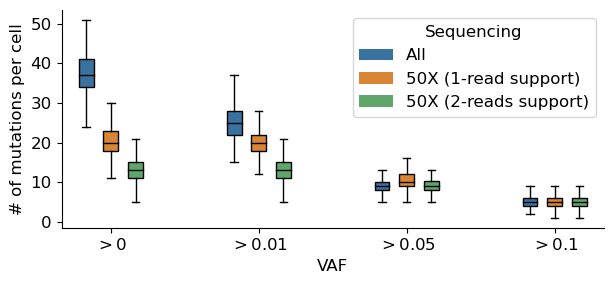

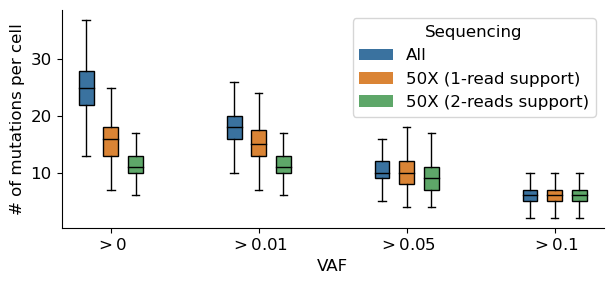

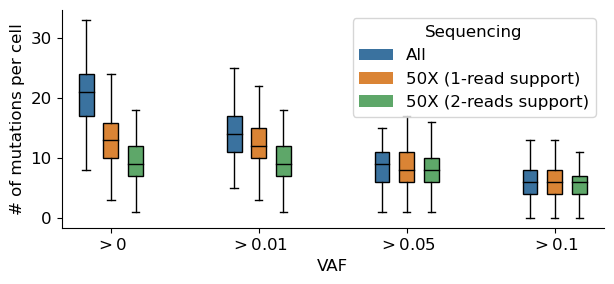

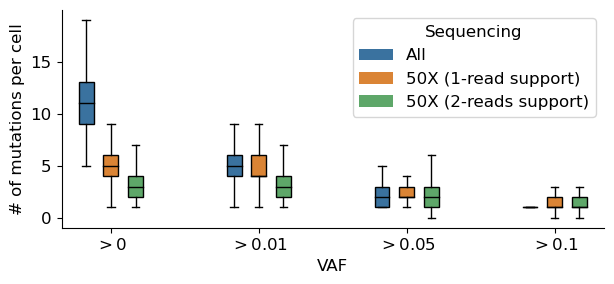

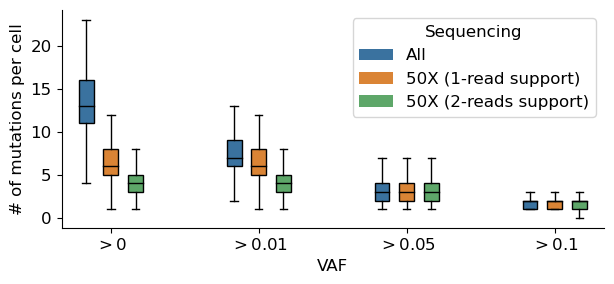

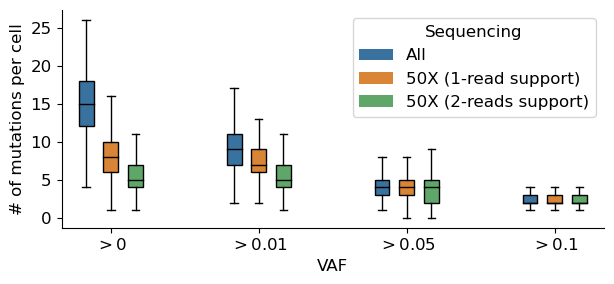

In [1505]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/292066/'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093/'
for path in ['/data3/wangkun/mtsim_res/20240903/const_100/11506/', '/data3/wangkun/mtsim_res/20240903/const_10/243093/']:
    if '_100' in path:
        hp = 100
    else:
        hp = 10
    for gen in [30, 130, 330]:
        mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
        mt_freq = sparse_freq(mts)
        if gen == 30:
            tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
            sel_cells = [i.name for i in tree.get_terminals()]
            mt_freq = mt_freq.loc[sel_cells]

        mt_freq_samp1, mt_freq_samp2 = sequence_sim(mt_freq, 50, n=2.5, min_reads=[1,2])

        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            for freq_i in (mt_freq, mt_freq_samp1, mt_freq_samp2):
                num_vaf.append(np.sum(freq_i>i, axis=1).to_numpy())
        fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
        medianprops = dict(color='black')
        bp = ax.boxplot(num_vaf, positions=[0.5,1,1.5,3.5,4,4.5,6.5,7,7.5,9.5,10,10.5],
                        widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        colors=['#3a729f','#da8435', '#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_ylabel('# of mutations per cell')
        legend_elements = []
        legend_elements.append(Patch(facecolor='#3a729f',label='All'))
        legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
        legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
        ax.legend(handles=legend_elements, title='Sequencing', loc=1)
        ax.set_xticks([1,4,7,10], 
                      ['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        plt.tight_layout()
        plt.savefig(f'../figs/vaf_{gen}_heterp{hp}_r2.pdf')

In [1349]:
from collections import Counter
def write_clone_color(path, header=False):
    '''
    header: for itol dataset
    '''
    for gen in ['_30', '_130', '_330']:
        treegt = Phylo.read(f'{path}/gt_tree{gen}.nwk'.replace('_30', ''), 'newick')
        if gen == '_30':
            for i in treegt.get_terminals():
                for j in treegt.get_path(i)[::-1][1:]:
                    if len(j.clades) == 1:
                        treegt.collapse(j)
            Phylo.write(treegt, f'{path}/gt_tree{gen}.nwk','newick')
        clones = [i.name.split('>')[0]+'>' for i in treegt.get_terminals()]
        clones_cnt = Counter(clones)
        # clones = list(set([i.name.split('>')[0]+'>' for i in treegt.get_terminals()]))
        # colors = ['#5D8AA8','#E32636','#FFBF00','#A4C639','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#FF9966','#6D351A','#007FFF','#89CFF0','#98777B','#DE5D83','#66FF00','#BF94E4','#FF007F','#004225','#FFC1CC','#800020']
        colors = ['#5BD17E','#D6D0FA','#FA937F','#C6E7CE','#E48DD0','#FFC33C','#8AE0DF','#82B329','#7475E6','#FBE2B4','#8F4851','#2040BD','#A5BFFA','#B500EB','#00992B','#724094','#FC6621','#CC2A27','#C2459F','#670755']        
        header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']
        # header = []
        if len(clones_cnt.keys()) <= 20:
            color_tab = dict(zip([i[0] for i in clones_cnt.most_common()], colors[:len(clones_cnt.keys())]))
            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for i in treegt.get_terminals():
                    f.write(f"{i.name} {color_tab[i.name.split('>')[0]+'>']}\n")
        else:
            progenitors = [treegt.root]
            iters = 0
            while len(progenitors)<20:
                iters += 1
                if iters > 100:
                    print('unsuccess')
                    break
                try:
                    progenitors.append(progenitors[0].clades[0])
                    progenitors.append(progenitors[0].clades[1])
                except:
                    pass
                progenitors.pop(0)
            cnt = [len(i.get_terminals()) for i in progenitors]
            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for ind, i in enumerate(np.argsort(cnt)[::-1]):
                    for j in progenitors[i].get_terminals():
                        f.write(f'{j.name} {colors[ind]}\n')


In [1350]:
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/', '/data3/wangkun/mtsim_res/20240903/const_100/']:
    for simid in tqdm(os.listdir(path)):
        write_clone_color(f'{path}/{simid}', header=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [98]:
def robinson_foulds(tree1:'Bio.Phylo.BaseTree', tree2:'Bio.Phylo.BaseTree'):
    f = StringIO()
    Phylo.write(tree1, f, 'newick')
    tree1 = Tree(f.getvalue(), format=1)
    # tree1.prune(tree1.get_leaf_names())
    f = StringIO()
    Phylo.write(tree2, f, 'newick')
    tree2 = Tree(f.getvalue(), format=1)
    # tree2.prune(tree2.get_leaf_names())
    try:
        return tree1.robinson_foulds(tree2)
    except:
        return tree1.robinson_foulds(tree2, unrooted_trees=True)

In [1578]:
def get_gt_dist(tree_mt, tree_gt, niter=100, verbose=False):
    pairs = []
    cnt = 0
    tree_mt_copy = deepcopy(tree_mt)
    all_cells = tree_mt_copy.get_terminals()
    for i in tree_mt_copy.get_terminals():
        i.branch_length=1
    for i in tree_mt_copy.get_nonterminals():
        i.branch_length=1
    if verbose:
        pbar = tqdm(total=niter)

    while cnt < niter:
        c1 = all_cells[np.random.choice(range(len(all_cells)))]
        for anc in tree_mt_copy.get_path(c1)[::-1][1:]:
            if len(anc.get_terminals())<2:
                continue
            siss, dists = [], []
            for sis in anc.get_terminals():
                siss.append(sis)
                dists.append(tree_mt_copy.distance(c1, sis))

            c2 = siss[np.where(np.argsort(dists)==len(dists)-1)[0][0]]
            pairs.append((c1.name, c2.name))
            cnt += 1
            if verbose:
                pbar.update(1)
            break
            
    dist_gt = []
    for i in pairs:
        c1, c2 = tree_gt.find_any(i[0]), tree_gt.find_any(i[1])
        dist_gt.append(tree_gt.distance(c1, c2))
    return np.array(dist_gt)/2

In [1582]:
terminal_bl_data = dict()
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/243093/','/data3/wangkun/mtsim_res/20240903/const_100/292066/']:
    for gen in [30, 130, 330]: 
        tree_gt = Phylo.read(f'{path}/gt_tree_{gen}.nwk', 'newick')
        tree_mt = Phylo.read(f'{path}/mt_allmuts_{gen}_0.phy_nj.nwk', 'newick')
        tree_ndna = Phylo.read(f'{path}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), 'newick')
        tree_mt1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01.phy_nj.nwk', 'newick')
        tree_mt_seq1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0_seq1.phy_nj.nwk', 'newick')
        tree_mt1_seq1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01_seq1.phy_nj.nwk', 'newick')
        tree_mt_seq2 = Phylo.read(f'{path}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', 'newick')
        tree_mt1_seq2 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', 'newick')

        niter = 500
        dist_mt10 = get_gt_dist(tree_mt, tree_gt, niter=niter)
        dist_ndna10 = get_gt_dist(tree_ndna, tree_gt, niter=niter)
        dist_mt110 = get_gt_dist(tree_mt1, tree_gt, niter=niter)
        dist_mt_seq110 = get_gt_dist(tree_mt_seq1, tree_gt, niter=niter)
        dist_mt1_seq110 = get_gt_dist(tree_mt1_seq1, tree_gt, niter=niter)
        dist_mt_seq210 = get_gt_dist(tree_mt_seq2, tree_gt, niter=niter)
        dist_mt1_seq210 = get_gt_dist(tree_mt1_seq2, tree_gt, niter=niter)
        dist_gt10 = get_gt_dist(tree_gt, tree_gt, niter=niter)
        dist_random10 = []
        cells_gt = tree_gt.get_terminals()
        for _ in range(niter):
            c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
            dist_random10.append(tree_gt.distance(cells_gt[c1], cells_gt[c2])/2)
            
        if 'const_100' in path:
            terminal_bl_data[f'100_{gen}'] = [dist_gt10, dist_ndna10, dist_mt10, dist_mt_seq110, dist_mt_seq210, dist_mt110, dist_mt1_seq110, dist_mt1_seq210, dist_random10]
        else:
            terminal_bl_data[f'10_{gen}'] = [dist_gt10, dist_ndna10, dist_mt10, dist_mt_seq110, dist_mt_seq210, dist_mt110, dist_mt1_seq110, dist_mt1_seq210, dist_random10]
       

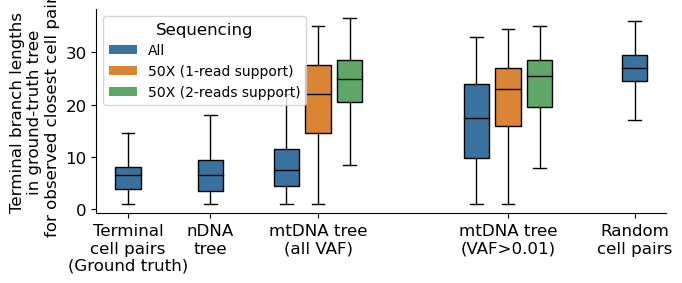

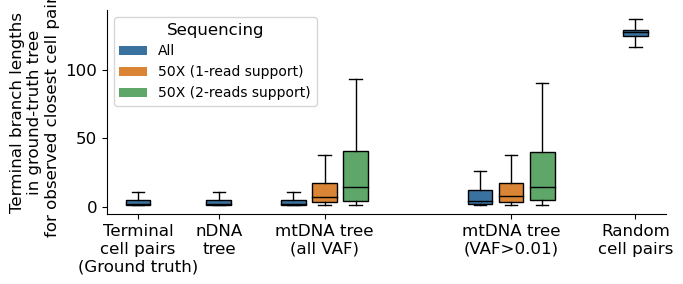

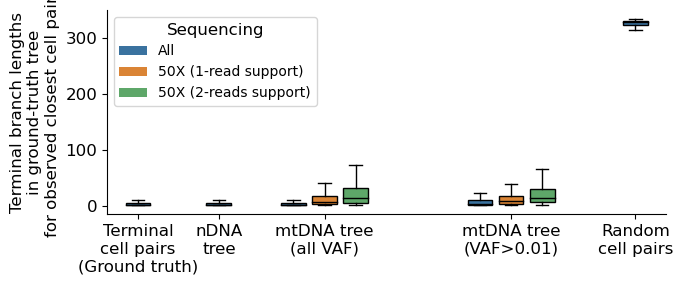

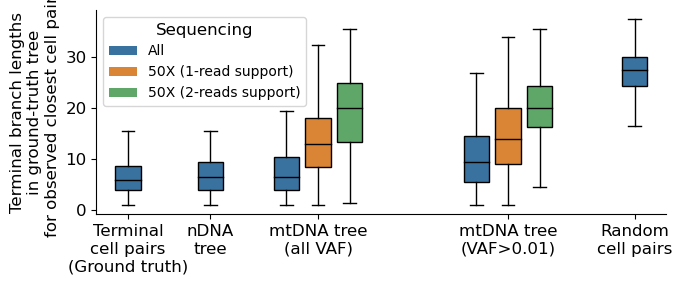

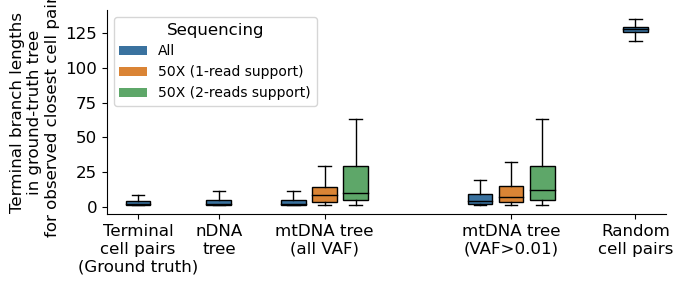

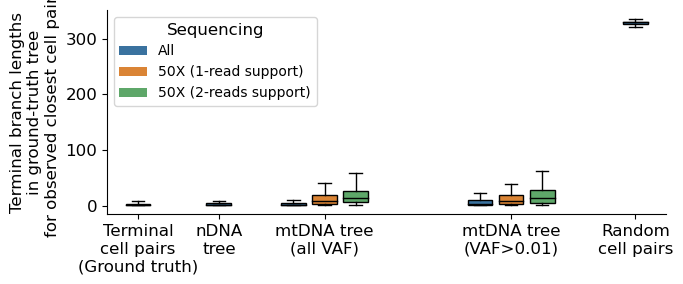

In [1583]:
for heterp in [10, 100]:
    for gen in [30, 130, 330]:
        fig, ax = plt.subplots(figsize=(7,3))
        bp = ax.boxplot(terminal_bl_data[f'{heterp}_{gen}'], widths=0.4, patch_artist=True, medianprops=medianprops,showfliers=False,
                        positions=[1,2.3,3.5,4,4.5,6.5,7,7.5,9]
                       )

        colors = ['#3a729f','#3a729f','#3a729f','#da8435', '#5ea769','#3a729f','#da8435', '#5ea769', '#3a729f'] 
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        legend_elements = []
        legend_elements.append(Patch(facecolor='#3a729f',label='All'))
        legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
        legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
        ax.legend(handles=legend_elements, title='Sequencing', loc=2, fontsize=10)

        ax.set_xticks([1,2.3,4, 7, 9], 
                      ['Terminal\ncell pairs\n(Ground truth)','nDNA\ntree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)', 'Random\ncell pairs'])
        ax.set_ylabel('Terminal branch lengths\nin ground-truth tree\nfor observed closest cell pairs')
        # ax.set_title('Root cell heteroplasmy = 10')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()
        plt.savefig(f'../figs/terminal_bl_{gen}_h{heterp}_r2.pdf')

In [284]:
mt30 = pickle.load(open(f'{path}/mt_allmuts_30.pkl', 'rb'))
mt130 = pickle.load(open(f'{path}/mt_allmuts_130.pkl', 'rb'))
mt330 = pickle.load(open(f'{path}/mt_allmuts_330.pkl', 'rb'))

In [343]:
freq_30 = sparse_freq(mt30).loc[[i.name for i in tree_gt.get_terminals()]]
freq_130 = sparse_freq(mt130)
freq_330 = sparse_freq(mt330)

  0%|          | 0/9326 [00:00<?, ?it/s]

  0%|          | 0/1141 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

In [344]:
cnt_30 = Counter([i.split('>')[0] for i in freq_30.index])
cnt_130 = Counter([i.split('>')[0] for i in freq_130.index])
cnt_330 = Counter([i.split('>')[0] for i in freq_330.index])

In [363]:
muller_data = []
for i in np.random.choice(freq_30.index, 20, replace=False):
    i = i[:-1]
    data_i = [1]
    if i in cnt_330:
        data_i.append(cnt_130[i])
        data_i.append(cnt_330[i])
    else:
        
        if i in cnt_130:
            data_i.append(cnt_130[i])
            data_i.append(0)
        else:
            data_i.append(0)
            data_i.append(0)
    
    muller_data.append(data_i)

In [364]:
pd.DataFrame(muller_data).to_csv('/data3/wangkun/mtsim_res/20240903/test/muller_20.csv')

In [626]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/112603'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
tree_mt = Phylo.read(f'{path}/mt_allmuts_30_0.phy_nj.nwk', 'newick')
tree_ndna = Phylo.read(f'{path}/dna_mut.phy_nj.nwk', 'newick')
tree_mt1 = Phylo.read(f'{path}/mt_allmuts_30_0.01.phy_nj.nwk', 'newick')
tree_mt_seq = Phylo.read(f'{path}/mt_allmuts_30_0_seq.phy_nj.nwk', 'newick')
tree_mt1_seq = Phylo.read(f'{path}/mt_allmuts_30_0.01_seq.phy_nj.nwk', 'newick')


In [1353]:
from collections import defaultdict
def write_rf_colors(tree_gt, tree_mt, output):
    betas_gt = []
    for i in tree_gt.get_nonterminals():
        betas_gt.append([j.name for j in i.get_terminals()])
    mt_color = defaultdict(float)
    for i in tree_mt.get_nonterminals():
        terminals_tmp = [j.name for j in i.get_terminals()]
        if not terminals_tmp in betas_gt:
            for j in terminals_tmp:
                mt_color[j] =  max(mt_color[j], 0)
        else:
            for j in terminals_tmp:
                mt_color[j] =  1
    header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']            
    color_tab = ['#F4684B', '#7FF593']
    with open(output, 'w') as f:
        f.write('\n'.join(header))
        f.write('\n')
        for i in mt_color:
            f.write(f'{i} {color_tab[int(mt_color[i])]}\n')
    return None 

In [1354]:
# path = '/data3/wangkun/mtsim_res/20240903/const_100/292066'
path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for i in [i for i in os.listdir(path) if i[-3:] == 'nwk']:
    if '_30' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
    elif '_130' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_130.nwk', 'newick')
    else:
        tree_gt = Phylo.read(f'{path}/gt_tree_330.nwk', 'newick')
    tree_mt = Phylo.read(f'{path}/{i}', 'newick')
    write_rf_colors(tree_gt, tree_mt, f'{path}/rf_color_{i}.txt')

In [1356]:
path = '/data3/wangkun/mtsim_res/20240903/const_100/34468'
# path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for i in [i for i in os.listdir(path) if i[-3:] == 'nwk']:
    if '_30' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
    elif '_130' in i:
        tree_gt = Phylo.read(f'{path}/gt_tree_130.nwk', 'newick')
    else:
        tree_gt = Phylo.read(f'{path}/gt_tree_330.nwk', 'newick')
    tree_mt = Phylo.read(f'{path}/{i}', 'newick')
    write_rf_colors(tree_gt, tree_mt, f'{path}/rf_color_{i}.txt')

In [1234]:
def clone_aggregation_score(tree_file, state_file):
    with open(state_file, 'r') as f:
        color_file = f.readlines()
    cell_states = dict()
    for i in color_file:
        try:
            cell, state = i.split(' ')
            cell_states[cell] = state.strip()
        except:
            pass
    tree_mt = Phylo.read(tree_file, 'newick') 
    state_mt = []
    for i in tree_mt.get_terminals():
        try:
            state_mt.append(cell_states[i.name])
        except:
            state_mt.append('0')
    state_diff_mt = 0
    for i, j in zip(state_mt[:-1], state_mt[1:]):
        if i!=j:
            state_diff_mt += 1
    return 1-np.log(len(set(state_mt))/state_diff_mt)/np.log(len(set(state_mt))/len(state_mt))

In [1345]:
cas_100 = []
path = '/data3/wangkun/mtsim_res/20240903/const_100/'
for simid in tqdm(os.listdir(path)):
    cast = []
    for gen in [30, 130, 330]:
        cast.append(clone_aggregation_score(f'{path}/{simid}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
    cas_100.append(cast)
    
cas_10 = []
path = '/data3/wangkun/mtsim_res/20240903/const_10/'
for simid in tqdm(os.listdir(path)):
    cast = []
    for gen in [30, 130, 330]:
        cast.append(clone_aggregation_score(f'{path}/{simid}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
    cas_10.append(cast)
cas_10 = pd.DataFrame(cas_10)
cas_100 = pd.DataFrame(cas_100)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

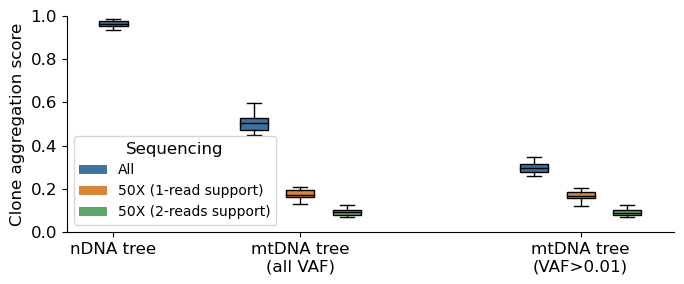

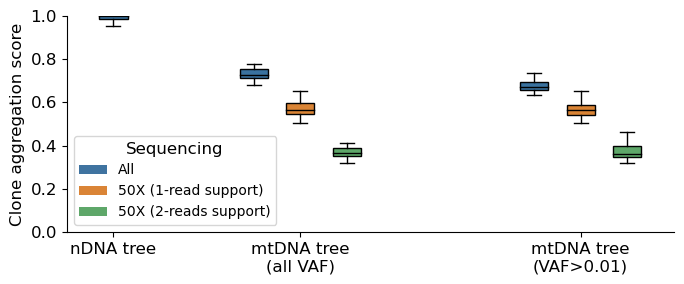

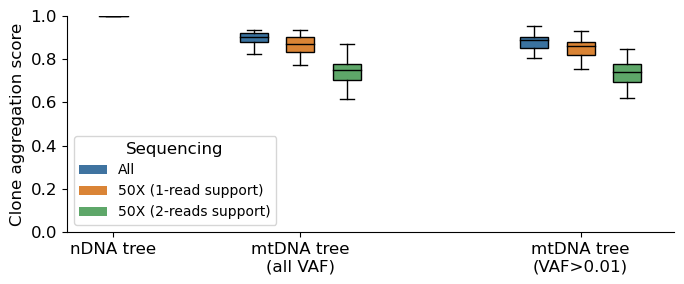

In [1346]:
for i,gen in zip(range(3), [30,130,330]):
    fig, ax = plt.subplots(figsize=(7,3))
    medianprops = dict(color='black')
    bp = ax.boxplot(cas_10.iloc[:,i*7:(i+1)*7], positions=[0, 1.5,2,2.5,4.5,5,5.5],
                    widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
    colors=['#3a729f','#3a729f','#da8435','#5ea769', '#3a729f','#da8435', '#5ea769']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    legend_elements = []
    legend_elements.append(Patch(facecolor='#3f73a0',label='All'))
    legend_elements.append(Patch(facecolor='#da8436',label='50X (1-read support)'))
    legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
    ax.legend(handles=legend_elements, title='Sequencing', loc=3, fontsize=10)
    ax.set_ylabel('Clone aggregation score')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,2, 5], 
                  ['nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)'])
    ax.set_ylim((0,1))
    plt.tight_layout()
    plt.savefig(f'../figs/cas_h10_{gen}_2r.pdf')

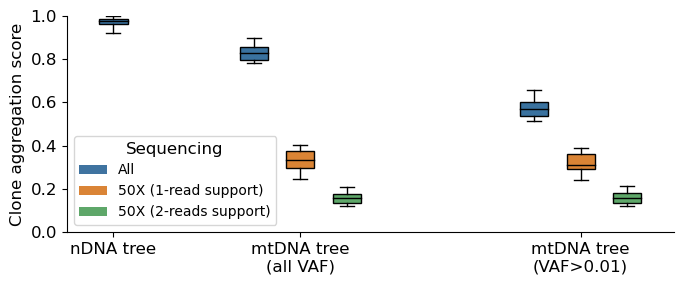

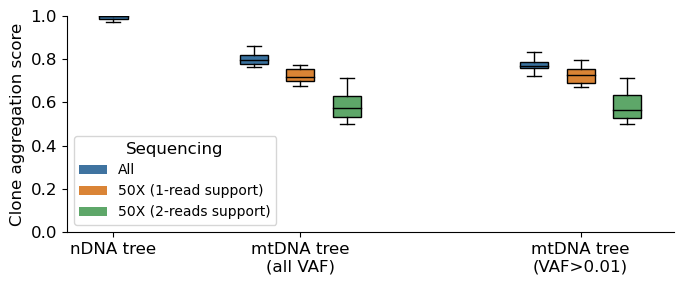

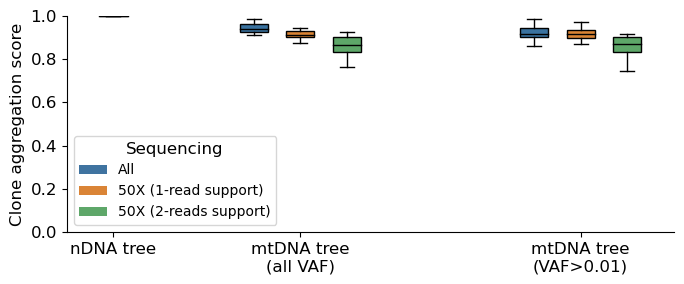

In [1325]:
for i,gen in zip(range(3), [30,130,330]):
    fig, ax = plt.subplots(figsize=(7,3))
    medianprops = dict(color='black')
    bp = ax.boxplot(cas_100.iloc[:,i*7:(i+1)*7], positions=[0, 1.5,2,2.5,4.5,5,5.5],
                    widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
    colors=['#3a729f','#3a729f','#da8435','#5ea769', '#3a729f','#da8435', '#5ea769']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    legend_elements = []
    legend_elements.append(Patch(facecolor='#3f73a0',label='All'))
    legend_elements.append(Patch(facecolor='#da8436',label='50X (1-read support)'))
    legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
    ax.legend(handles=legend_elements, title='Sequencing', loc=3, fontsize=10)
    ax.set_ylabel('Clone aggregation score')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,2, 5], 
                  ['nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)'])
    ax.set_ylim((0,1))
    plt.tight_layout()
    plt.savefig(f'../figs/cas_h100_{gen}_2r.pdf')

In [785]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailabl

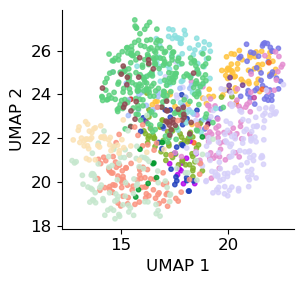

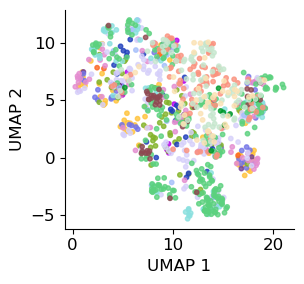

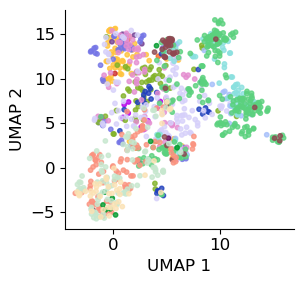

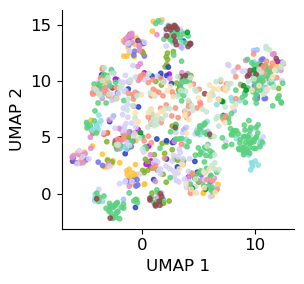

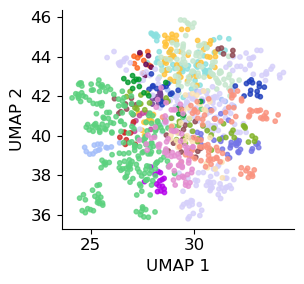

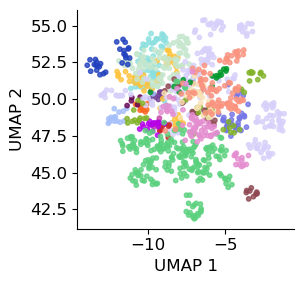

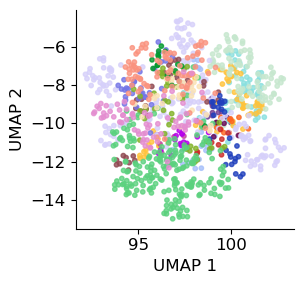

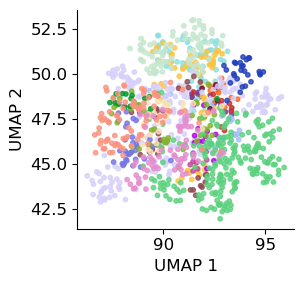

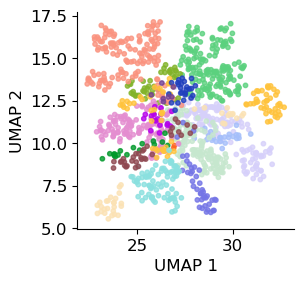

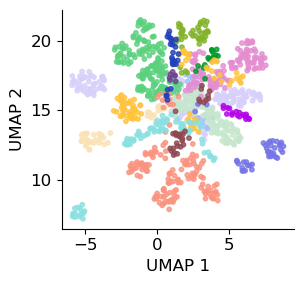

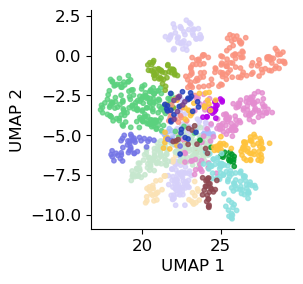

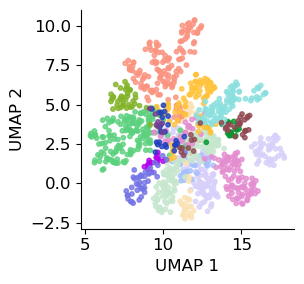

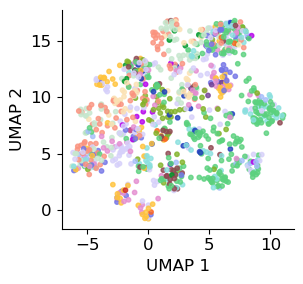

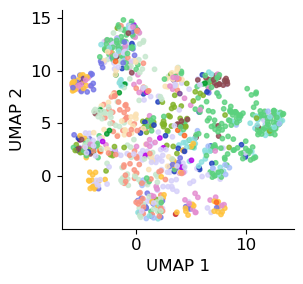

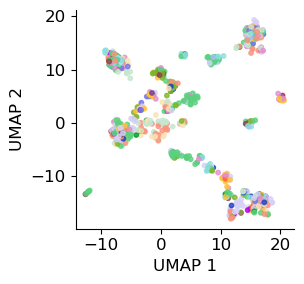

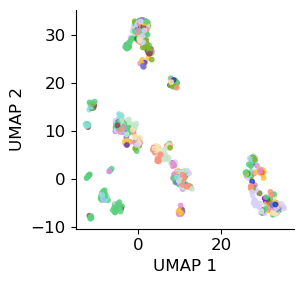

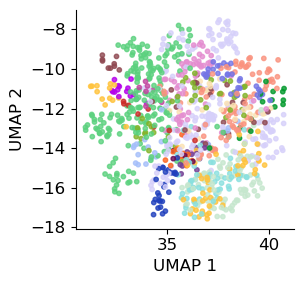

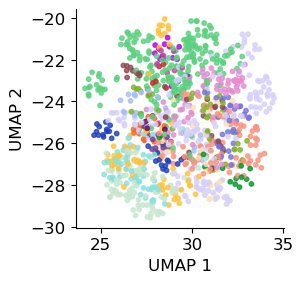

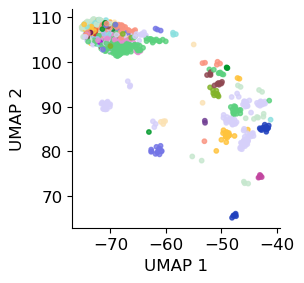

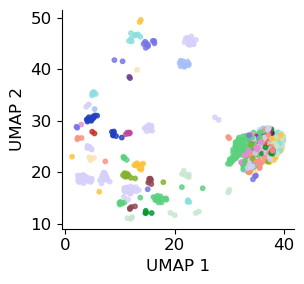

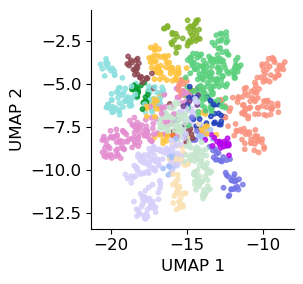

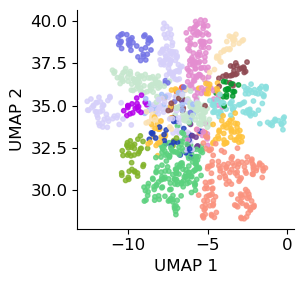

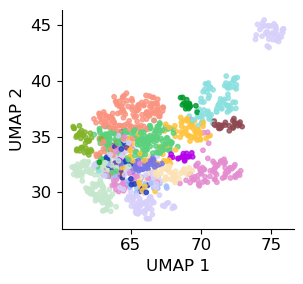

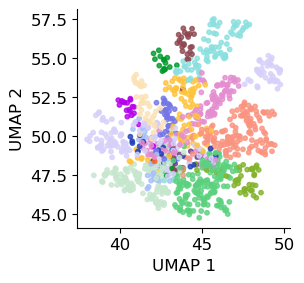

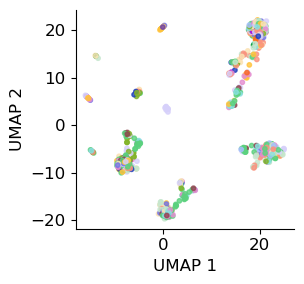

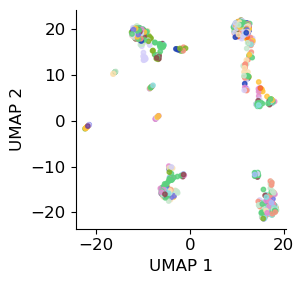

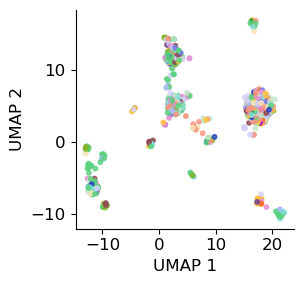

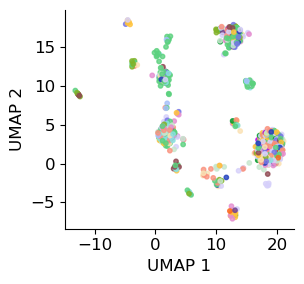

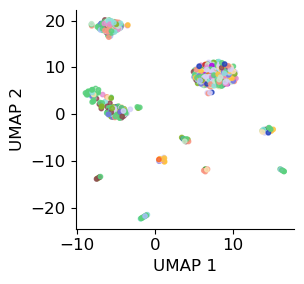

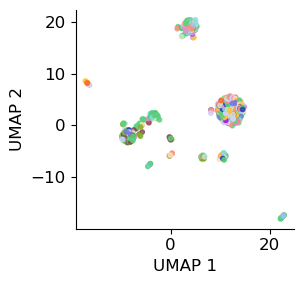

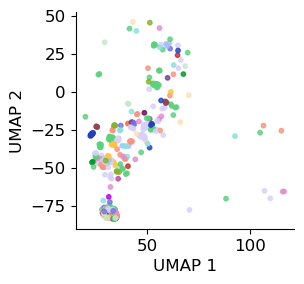

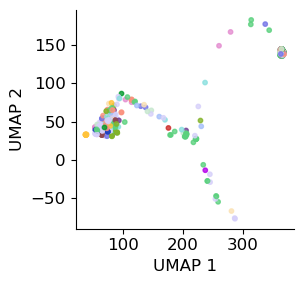

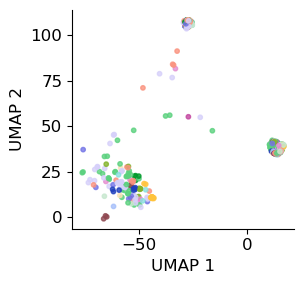

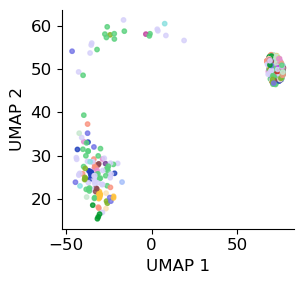

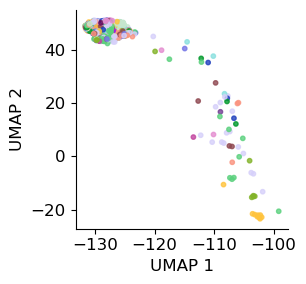

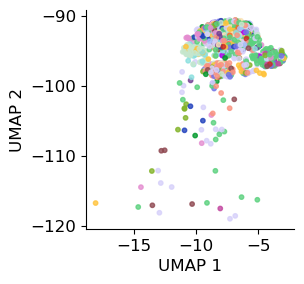

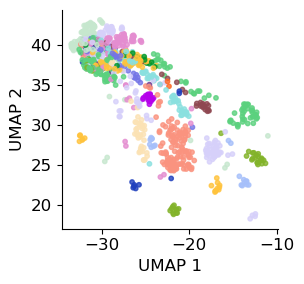

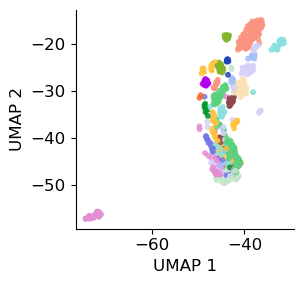

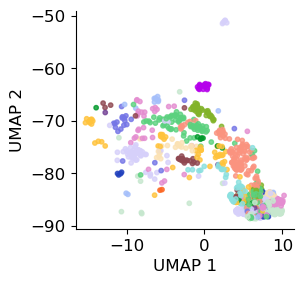

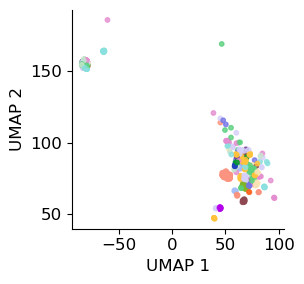

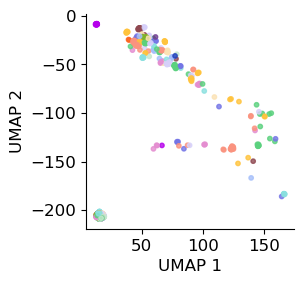

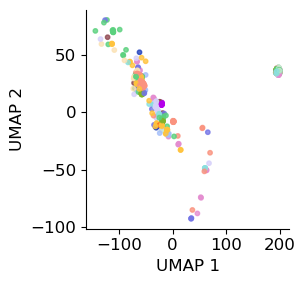

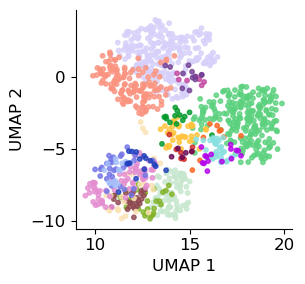

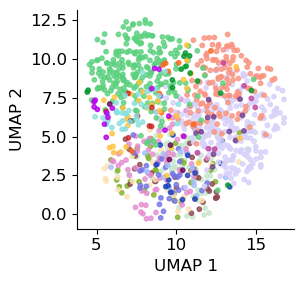

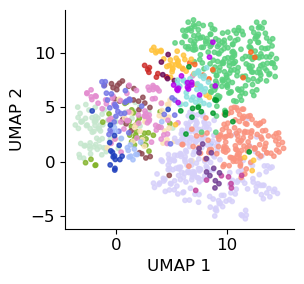

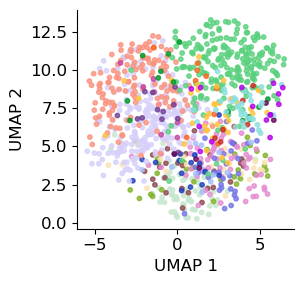

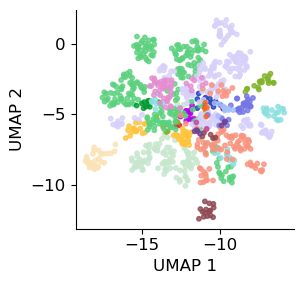

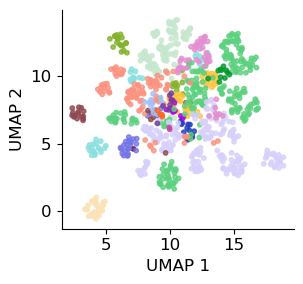

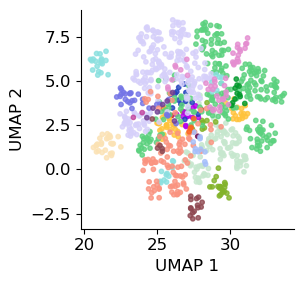

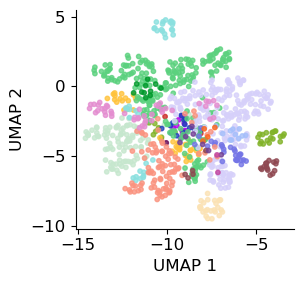

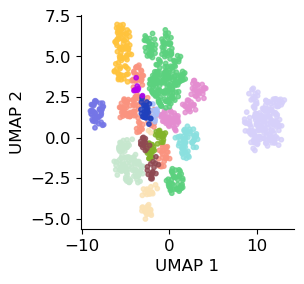

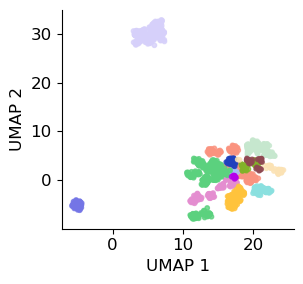

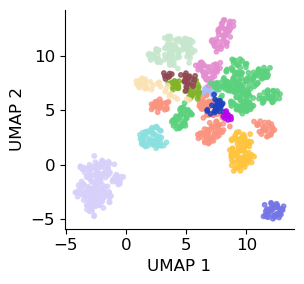

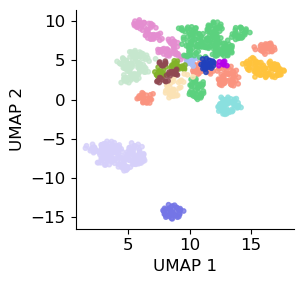

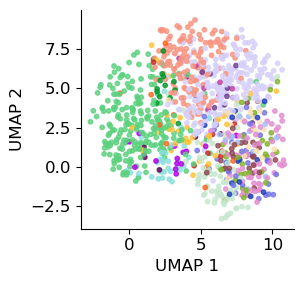

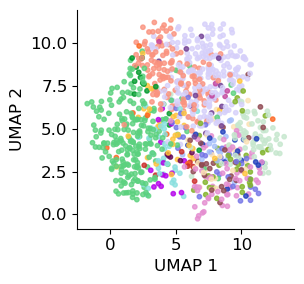

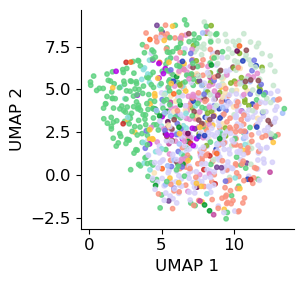

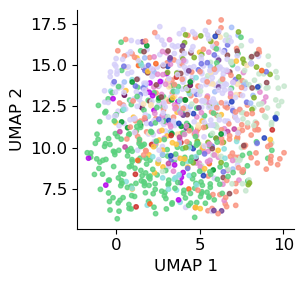

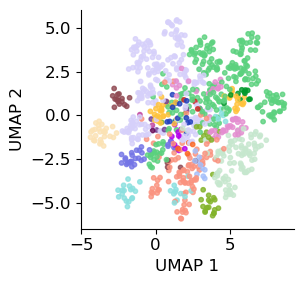

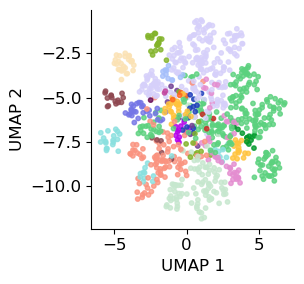

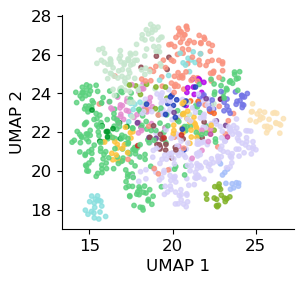

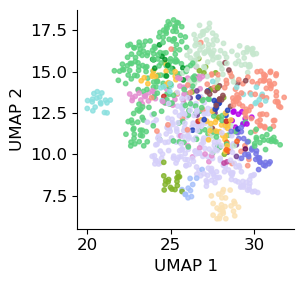

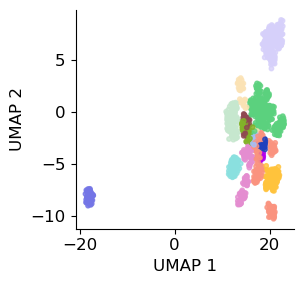

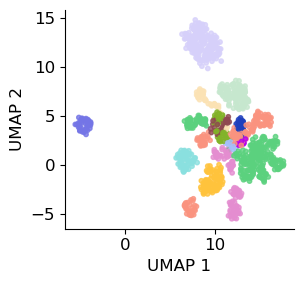

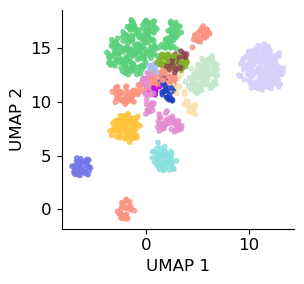

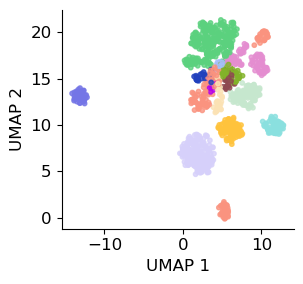

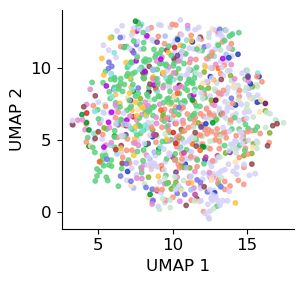

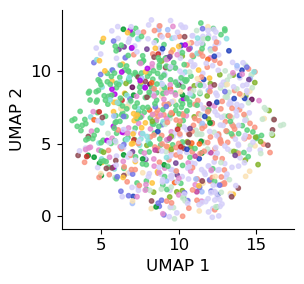

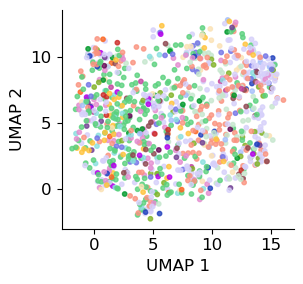

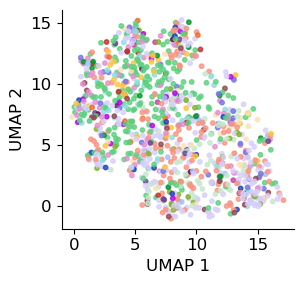

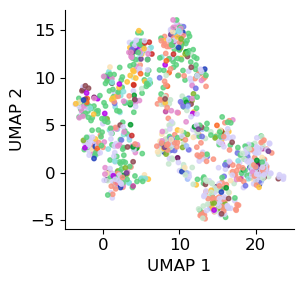

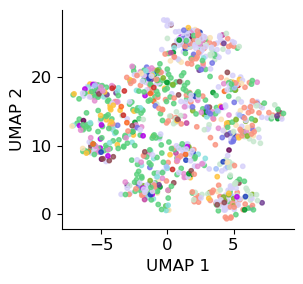

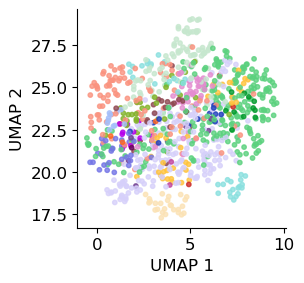

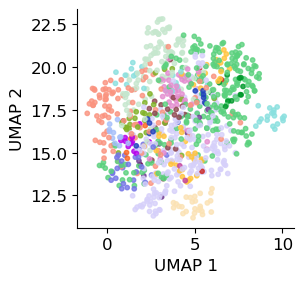

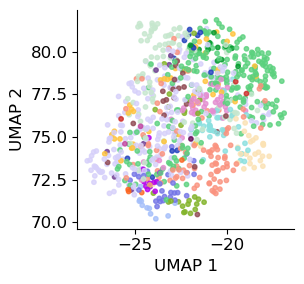

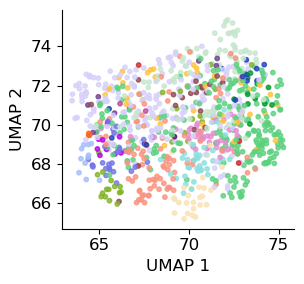

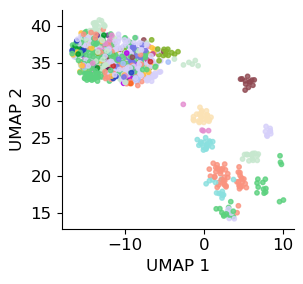

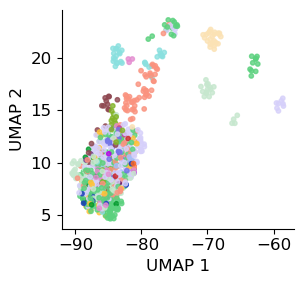

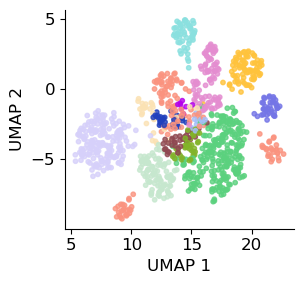

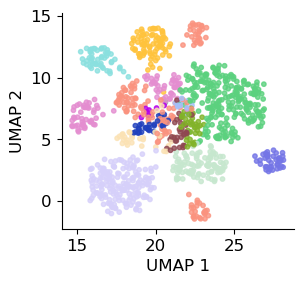

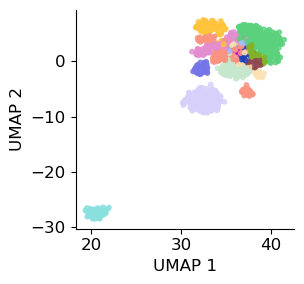

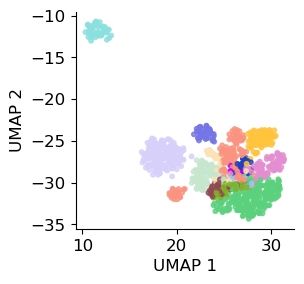

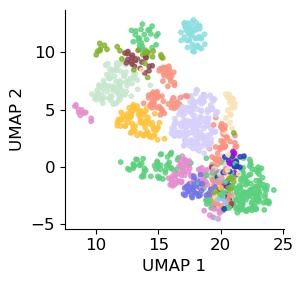

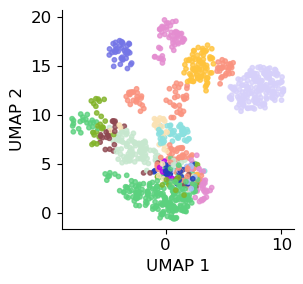

In [1352]:
path = '/data3/wangkun/mtsim_res/20240903/const_100/34468'
# path =  '/data3/wangkun/mtsim_res/20240903/const_10/243093'
for path in ['/data3/wangkun/mtsim_res/20240903/const_10/243093', '/data3/wangkun/mtsim_res/20240903/const_100/34468']:
    for file in [i for i in os.listdir(path) if i[-3:] =='phy']:
        if 'dna' in file:
            continue
        if '_30' in file:
            color_file = 'tree_color_30.txt'
        elif '_130' in file:
            color_file = 'tree_color_130.txt'
        else:
            color_file = 'tree_color_330.txt'
        with open(f'{path}/{color_file}', 'r') as f:
            colors = f.readlines()
        color_dict = dict()
        for i in colors[6:]:
            cell, col = i.split(' ')
            color_dict[cell] = col.strip()

        with open(f'{path}/{file}', 'r') as f:
            seqs = f.readlines()
        seqs = seqs[1:]
        translation_table = str.maketrans({'A': '1', 'G': '0'})
        muttab = []
        cell_names = []
        for i in seqs:
            muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
            cell_names.append(i.split(' ')[0])
        mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
        # X_pc100 = PCA(n_components=100).fit_transform(mutdf)
        if ('_30' in file) and (file != 'mt_allmuts_30_0.phy'):
            mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=5, metric='hamming').fit_transform(mutdf)
        else:
            mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=100, metric='hamming').fit_transform(mutdf)
        # mut_umap = TSNE(n_components=2, perplexity=500).fit_transform(mutdf)
        fig, ax = plt.subplots(1, 1, figsize=(3.2,3))
        scat_color = []
        for i in mutdf.index:
            try:
                scat_color.append(color_dict[i])
            except:
                scat_color.append('#FFFFFF')
        ax.scatter(mut_umap[:,0], mut_umap[:,1], s=10, alpha=0.8,c=scat_color)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        plt.tight_layout()
        if '_100' in path:
            plt.savefig(f'../figs/umap_100/{file}.pdf')
        else:
            plt.savefig(f'../figs/umap_10/{file}.pdf')

In [1371]:
init_vaf_10= []
path = '/data3/wangkun/mtsim_res/20240903/const_10/'
for simid in os.listdir(path):
    mt_muts = pickle.load(open(f'{path}/{simid}/mt_allmuts_30.pkl', 'rb'))
    init_vaf_10.append(sparse_freq({'<0_0>':mt_muts['<0_0>']}).to_numpy().flatten())
    
init_vaf_100 = []
path = '/data3/wangkun/mtsim_res/20240903/const_100/'
for simid in os.listdir(path):
    mt_muts = pickle.load(open(f'{path}/{simid}/mt_allmuts_30.pkl', 'rb'))
    init_vaf_100.append(sparse_freq({'<0_0>':mt_muts['<0_0>']}).to_numpy().flatten())

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [1381]:
init_vaf_10 = sum([list(i) for i in init_vaf_10], [])
init_vaf_100 = sum([list(i) for i in init_vaf_100], [])

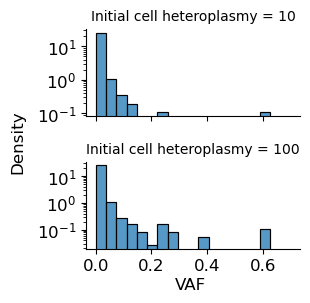

In [1589]:
fig, ax = plt.subplots(2,1, figsize=(3.2,3),sharex=True)
sns.histplot(np.random.choice(init_vaf_10,1000),bins=np.linspace(0,0.7,20), stat='density', ax=ax[0])
sns.histplot(np.random.choice(init_vaf_100,1000),bins=np.linspace(0,0.7,20), stat='density', ax=ax[1])
ax[0].set_yscale("log",base=10)
ax[1].set_yscale("log",base=10)
ax[0].set_ylabel(' ')
ax[1].set_ylabel(' ')
fig.text(0.06, 0.5, 'Density', ha='center', va='center', rotation='vertical')
fig.text(0.6, 0.02, 'VAF', ha='center', va='center')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_title('Initial cell heteroplasmy = 10', fontsize=10)
ax[1].set_title('Initial cell heteroplasmy = 100', fontsize=10)
plt.tight_layout()
plt.savefig('../figs/initial_vaf.pdf')

In [1445]:
remain_lin_130 = []
remain_lin_330 = []
path = '/data3/wangkun/mtsim_res/20240903/const_10/'
for simid in os.listdir(path):
    mt_muts = pickle.load(open(f'{path}/{simid}/mt_allmuts_130.pkl', 'rb'))
    freq = sparse_freq(mt_muts)
    remain_lin_130.append(len(set([i.split('>')[0] for i in freq.index])))
    mt_muts = pickle.load(open(f'{path}/{simid}/mt_allmuts_330.pkl', 'rb'))
    freq = sparse_freq(mt_muts)
    remain_lin_330.append(len(set([i.split('>')[0] for i in freq.index])))

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1098 [00:00<?, ?it/s]

  0%|          | 0/1154 [00:00<?, ?it/s]

  0%|          | 0/950 [00:00<?, ?it/s]

  0%|          | 0/869 [00:00<?, ?it/s]

  0%|          | 0/1021 [00:00<?, ?it/s]

  0%|          | 0/941 [00:00<?, ?it/s]

  0%|          | 0/1121 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/925 [00:00<?, ?it/s]

  0%|          | 0/896 [00:00<?, ?it/s]

  0%|          | 0/1125 [00:00<?, ?it/s]

  0%|          | 0/1202 [00:00<?, ?it/s]

  0%|          | 0/980 [00:00<?, ?it/s]

  0%|          | 0/953 [00:00<?, ?it/s]

  0%|          | 0/888 [00:00<?, ?it/s]

  0%|          | 0/917 [00:00<?, ?it/s]

  0%|          | 0/1145 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/1136 [00:00<?, ?it/s]

  0%|          | 0/860 [00:00<?, ?it/s]

  0%|          | 0/932 [00:00<?, ?it/s]

  0%|          | 0/908 [00:00<?, ?it/s]

  0%|          | 0/867 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

  0%|          | 0/854 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/915 [00:00<?, ?it/s]

  0%|          | 0/1123 [00:00<?, ?it/s]

  0%|          | 0/1157 [00:00<?, ?it/s]

  0%|          | 0/1146 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/881 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/918 [00:00<?, ?it/s]

  0%|          | 0/852 [00:00<?, ?it/s]

  0%|          | 0/1141 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/1139 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

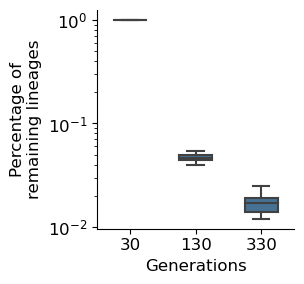

In [1591]:
fig, ax = plt.subplots(figsize=(3.2,3))
sns.boxplot(data=[[1]*20, np.array(remain_lin_130)/1000, np.array(remain_lin_330)/1000], ax=ax,color='#3a729f', width=0.5)
ax.set_yscale("log",base=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0,1,2], ['30', '130', '330'])
# ax.set_ylim([0.0000001,1])
ax.set_ylabel('Percentage of\nremaining lineages')
ax.set_xlabel('Generations')
plt.tight_layout()
plt.savefig('../figs/lineage_number.pdf')

In [1464]:
path = '/data3/wangkun/mtsim_res/20240903/const_10/243093'
mt_muts = pickle.load(open(f'{path}/mt_allmuts_30.pkl', 'rb'))
freq = sparse_freq(mt_muts)
tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
freq = freq.loc[[i.name for i in tree_gt.get_terminals()]]
depth = nbinom(p=n/(n+coverage), n=n).rvs(size=freq.shape)

  0%|          | 0/9137 [00:00<?, ?it/s]

In [1476]:
from matplotlib import ticker

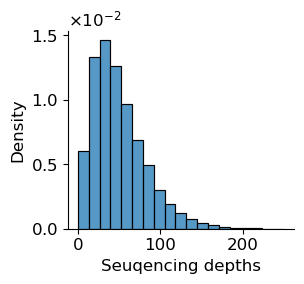

In [1587]:
fig, ax = plt.subplots(figsize=(3.2,3))
sns.histplot(depth.flatten(),bins=np.linspace(0, 250, 20), stat='density', ax=ax)
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((0,0)) 
ax.yaxis.set_major_formatter(formatter)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Seuqencing depths')
plt.tight_layout()
plt.savefig('../figs/depth_density.pdf')

In [1493]:
path = '/data3/wangkun/mtsim_res/20240903/const_10/285175'
mt_muts = pickle.load(open(f'{path}/mt_allmuts_30.pkl', 'rb'))
freq = sparse_freq(mt_muts)
tree_gt = Phylo.read(f'{path}/gt_tree_30.nwk', 'newick')
freq = freq.loc[[i.name for i in tree_gt.get_terminals()]]
depth = nbinom(p=n/(n+coverage), n=n).rvs(size=freq.shape)
freq_seq = sequence_sim(freq, 50)

  0%|          | 0/9147 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:788: RuntimeWarning: invalid value encountered in divide
  if hasattr(min_reads, '__iter__'):


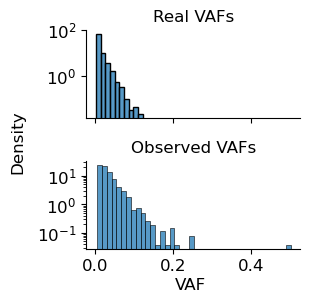

In [1590]:
fig, ax = plt.subplots(2,1, figsize=(3.2,3),sharex=True)
vaf_real = freq.to_numpy().flatten()
vaf_seq = freq_seq.to_numpy().flatten()
vaf_real = vaf_real[vaf_real!=0]
vaf_seq = vaf_seq[vaf_seq!=0]
sns.histplot(vaf_real, stat='density', ax=ax[0], bins=10)
sns.histplot(vaf_seq, stat='density', ax=ax[1], bins=40)
ax[0].set_ylabel(' ')
ax[1].set_ylabel(' ')
fig.text(0.06, 0.5, 'Density', ha='center', va='center', rotation='vertical')
fig.text(0.6, 0.02, 'VAF', ha='center', va='center')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_yscale("log",base=10)
ax[1].set_yscale("log",base=10)
ax[0].set_title('Real VAFs', fontsize=12)
ax[1].set_title('Observed VAFs', fontsize=12)
plt.tight_layout()
plt.savefig('../figs/obs_vaf.pdf')